In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.8.0+cpu
torchvision version: 0.23.0+cpu


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

d:\pytorch exercise\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [7]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    data_path = Path("data/")
    image_path = data_path / destination

    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [8]:
train_dir = image_path / "train"
test_dir = image_path / "test"

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])           
print(f"Manually created transforms: {manual_transforms}")

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x29530a61950>,
 ['pizza', 'steak', 'sushi'])

In [9]:
train_dir = image_path / "train"
test_dir = image_path / "test"

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

automatic_transforms = weights.transforms() 
print(f"Automatically created transforms: {automatic_transforms}")

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms, 
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x29531ef0810>,
 ['pizza', 'steak', 'sushi'])

In [10]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [11]:
for param in model.features.parameters():
    param.requires_grad = False

set_seeds()

model.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, 
              out_features=len(class_names),
              bias=True).to(device))

In [12]:
from torchinfo import summary
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
try:
    from torch.utils.tensorboard import SummaryWriter
except:
    print("[INFO] Couldn't find tensorboard... installing it.")
    !pip install -q tensorboard
    from torch.utils.tensorboard import SummaryWriter


# Create a writer with all default settings
writer = SummaryWriter()

[INFO] Couldn't find tensorboard... installing it.


In [16]:
from typing import Dict, List
from tqdm.auto import tqdm

from going_modular.going_modular.engine import train_step, test_step

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        # Add loss results to SummaryWriter
        writer.add_scalars(main_tag="Loss", 
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)

        # Add accuracy results to SummaryWriter
        writer.add_scalars(main_tag="Accuracy", 
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc}, 
                           global_step=epoch)
        
        # Track the PyTorch model architecture
        writer.add_graph(model=model, 
                         # Pass in an example input
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))
    
    # Close the writer
    writer.close()
    
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

In [17]:
set_seeds()
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]d:\pytorch exercise\venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch: 1 | train_loss: 1.0883 | train_acc: 0.4180 | test_loss: 0.8914 | test_acc: 0.6818


 20%|██        | 1/5 [00:35<02:22, 35.51s/it]

Epoch: 2 | train_loss: 0.8937 | train_acc: 0.6641 | test_loss: 0.8082 | test_acc: 0.7746


 40%|████      | 2/5 [01:07<01:40, 33.52s/it]

Epoch: 3 | train_loss: 0.7450 | train_acc: 0.8438 | test_loss: 0.7433 | test_acc: 0.7538


 60%|██████    | 3/5 [01:40<01:05, 32.99s/it]

Epoch: 4 | train_loss: 0.7797 | train_acc: 0.6992 | test_loss: 0.6849 | test_acc: 0.8040


 80%|████████  | 4/5 [02:13<00:33, 33.20s/it]

Epoch: 5 | train_loss: 0.6322 | train_acc: 0.7695 | test_loss: 0.6428 | test_acc: 0.8362


100%|██████████| 5/5 [02:45<00:00, 33.13s/it]


In [18]:
results

{'train_loss': [1.0882934033870697,
  0.8936692252755165,
  0.7449564337730408,
  0.7797180190682411,
  0.6321720816195011],
 'train_acc': [0.41796875, 0.6640625, 0.84375, 0.69921875, 0.76953125],
 'test_loss': [0.8914492328961691,
  0.808230479558309,
  0.7433455387751261,
  0.6849219600359598,
  0.6428378423055013],
 'test_acc': [0.6818181818181818,
  0.774621212121212,
  0.7537878787878788,
  0.8039772727272728,
  0.8361742424242425]}

In [20]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 26768), started 0:01:53 ago. (Use '!kill 26768' to kill it.)

In [21]:
def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [22]:
example_writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb0",
                               extra="5_epochs")

[INFO] Created SummaryWriter, saving to: runs\2025-09-09\data_10_percent\effnetb0\5_epochs...


In [23]:
from typing import Dict, List
from tqdm.auto import tqdm

# Add writer parameter to train()
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device, 
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:

    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

In [24]:
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data\pizza_steak_sushi directory exists, skipping download.
[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


In [25]:
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

test_dir = data_10_percent_path / "test"

print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data\pizza_steak_sushi\train
Training directory 20%: data\pizza_steak_sushi_20_percent\train
Testing directory: data\pizza_steak_sushi\test


In [26]:
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                 std=[0.229, 0.224, 0.225]) 

simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    normalize 
])

In [27]:
BATCH_SIZE = 32

train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
    test_dir=test_dir, 
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(test_dataloader)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 3 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


In [29]:
import torchinfo
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

summary(model=effnetb2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [30]:
print(f"Number of in_features to final layer of EfficientNetB2: {len(effnetb2.classifier.state_dict()['1.weight'][0])}")

Number of in_features to final layer of EfficientNetB2: 1408


In [ ]:
import torchvision
from torch import nn

OUT_FEATURES = len(class_names)

def create_effnetb0():
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    for param in model.features.parameters():
        param.requires_grad = False

    set_seeds()

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model


def create_effnetb2():
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    for param in model.features.parameters():
        param.requires_grad = False

    set_seeds()

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [33]:
effnetb0 = create_effnetb0() 
summary(model=effnetb0, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

[INFO] Created new effnetb0 model.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [35]:
effnetb2 = create_effnetb2()
summary(model=effnetb2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

[INFO] Created new effnetb2 model.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [36]:
num_epochs  =  [ 5 ,  10 ]
models  =  [ "effnetb0" ,  "effnetb2" ] 
train_dataloaders  =  { "data_10_percent" :  train_dataloader_10_percent , 
                     "data_20_percent" :  train_dataloader_20_percent }

In [37]:
from going_modular.going_modular.utils import save_model

set_seeds(seed=42)

experiment_number = 0

for dataloader_name, train_dataloader in train_dataloaders.items():

    for epochs in num_epochs: 

        for model_name in models:

            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            if model_name == "effnetb0":
                model = create_effnetb0() 
            else:
                model = create_effnetb2() 
            
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
    
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2025-09-09\data_10_percent\effnetb0\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]d:\pytorch exercise\venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
 20%|██        | 1/5 [00:25<01:43, 25.97s/it]

Epoch: 1 | train_loss: 1.0497 | train_acc: 0.4453 | test_loss: 0.9296 | test_acc: 0.4470


 40%|████      | 2/5 [00:52<01:18, 26.05s/it]

Epoch: 2 | train_loss: 0.9335 | train_acc: 0.5234 | test_loss: 0.8193 | test_acc: 0.6411


 60%|██████    | 3/5 [01:16<00:50, 25.48s/it]

Epoch: 3 | train_loss: 0.7878 | train_acc: 0.7305 | test_loss: 0.6944 | test_acc: 0.8864


 80%|████████  | 4/5 [01:42<00:25, 25.45s/it]

Epoch: 4 | train_loss: 0.6920 | train_acc: 0.8828 | test_loss: 0.6497 | test_acc: 0.8968


100%|██████████| 5/5 [02:07<00:00, 25.47s/it]

Epoch: 5 | train_loss: 0.6931 | train_acc: 0.7383 | test_loss: 0.6418 | test_acc: 0.8352
[INFO] Saving model to: models\07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5


[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2025-09-09\data_10_percent\effnetb2\5_epochs...


 20%|██        | 1/5 [00:28<01:53, 28.46s/it]

Epoch: 1 | train_loss: 1.0925 | train_acc: 0.3906 | test_loss: 0.9376 | test_acc: 0.7519


 40%|████      | 2/5 [00:56<01:25, 28.40s/it]

Epoch: 2 | train_loss: 0.9309 | train_acc: 0.6562 | test_loss: 0.8848 | test_acc: 0.7945


 60%|██████    | 3/5 [01:24<00:56, 28.28s/it]

Epoch: 3 | train_loss: 0.7975 | train_acc: 0.8320 | test_loss: 0.7377 | test_acc: 0.9384


 80%|████████  | 4/5 [01:54<00:28, 28.86s/it]

Epoch: 4 | train_loss: 0.7118 | train_acc: 0.7734 | test_loss: 0.7052 | test_acc: 0.9280


100%|██████████| 5/5 [02:24<00:00, 28.81s/it]

Epoch: 5 | train_loss: 0.6842 | train_acc: 0.7734 | test_loss: 0.7055 | test_acc: 0.8665
[INFO] Saving model to: models\07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10


[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2025-09-09\data_10_percent\effnetb0\10_epochs...


 10%|█         | 1/10 [00:26<03:57, 26.42s/it]

Epoch: 1 | train_loss: 1.0497 | train_acc: 0.4453 | test_loss: 0.9296 | test_acc: 0.4470


 20%|██        | 2/10 [00:51<03:25, 25.68s/it]

Epoch: 2 | train_loss: 0.9335 | train_acc: 0.5234 | test_loss: 0.8193 | test_acc: 0.6411


 30%|███       | 3/10 [01:16<02:55, 25.11s/it]

Epoch: 3 | train_loss: 0.7878 | train_acc: 0.7305 | test_loss: 0.6944 | test_acc: 0.8864


 40%|████      | 4/10 [01:42<02:35, 25.84s/it]

Epoch: 4 | train_loss: 0.6920 | train_acc: 0.8828 | test_loss: 0.6497 | test_acc: 0.8968


 50%|█████     | 5/10 [02:07<02:07, 25.49s/it]

Epoch: 5 | train_loss: 0.6931 | train_acc: 0.7383 | test_loss: 0.6418 | test_acc: 0.8352


 60%|██████    | 6/10 [02:34<01:43, 25.79s/it]

Epoch: 6 | train_loss: 0.5720 | train_acc: 0.9023 | test_loss: 0.5509 | test_acc: 0.8968


 70%|███████   | 7/10 [03:00<01:17, 25.94s/it]

Epoch: 7 | train_loss: 0.5508 | train_acc: 0.7969 | test_loss: 0.5324 | test_acc: 0.9176


 80%|████████  | 8/10 [03:26<00:51, 25.96s/it]

Epoch: 8 | train_loss: 0.5074 | train_acc: 0.8164 | test_loss: 0.5141 | test_acc: 0.9072


 90%|█████████ | 9/10 [03:52<00:26, 26.10s/it]

Epoch: 9 | train_loss: 0.5785 | train_acc: 0.7891 | test_loss: 0.5324 | test_acc: 0.8769


100%|██████████| 10/10 [04:19<00:00, 25.96s/it]

Epoch: 10 | train_loss: 0.4566 | train_acc: 0.8281 | test_loss: 0.4553 | test_acc: 0.8968
[INFO] Saving model to: models\07_effnetb0_data_10_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 4
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10


[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2025-09-09\data_10_percent\effnetb2\10_epochs...


 10%|█         | 1/10 [00:28<04:13, 28.16s/it]

Epoch: 1 | train_loss: 1.0925 | train_acc: 0.3906 | test_loss: 0.9376 | test_acc: 0.7519


 20%|██        | 2/10 [00:56<03:45, 28.23s/it]

Epoch: 2 | train_loss: 0.9309 | train_acc: 0.6562 | test_loss: 0.8848 | test_acc: 0.7945


 30%|███       | 3/10 [01:24<03:17, 28.21s/it]

Epoch: 3 | train_loss: 0.7975 | train_acc: 0.8320 | test_loss: 0.7377 | test_acc: 0.9384


 40%|████      | 4/10 [01:52<02:49, 28.17s/it]

Epoch: 4 | train_loss: 0.7118 | train_acc: 0.7734 | test_loss: 0.7052 | test_acc: 0.9280


 50%|█████     | 5/10 [02:21<02:21, 28.23s/it]

Epoch: 5 | train_loss: 0.6842 | train_acc: 0.7734 | test_loss: 0.7055 | test_acc: 0.8665


 60%|██████    | 6/10 [02:49<01:52, 28.22s/it]

Epoch: 6 | train_loss: 0.6171 | train_acc: 0.8047 | test_loss: 0.6172 | test_acc: 0.9280


 70%|███████   | 7/10 [03:17<01:24, 28.16s/it]

Epoch: 7 | train_loss: 0.5571 | train_acc: 0.8047 | test_loss: 0.6235 | test_acc: 0.8769


 80%|████████  | 8/10 [03:45<00:56, 28.13s/it]

Epoch: 8 | train_loss: 0.5715 | train_acc: 0.7852 | test_loss: 0.5641 | test_acc: 0.9280


 90%|█████████ | 9/10 [04:13<00:28, 28.24s/it]

Epoch: 9 | train_loss: 0.4797 | train_acc: 0.9180 | test_loss: 0.5521 | test_acc: 0.9384


100%|██████████| 10/10 [04:41<00:00, 28.19s/it]

Epoch: 10 | train_loss: 0.5223 | train_acc: 0.8164 | test_loss: 0.5839 | test_acc: 0.8466
[INFO] Saving model to: models\07_effnetb2_data_10_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 5
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5


[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2025-09-09\data_20_percent\effnetb0\5_epochs...


 20%|██        | 1/5 [00:31<02:05, 31.36s/it]

Epoch: 1 | train_loss: 0.9679 | train_acc: 0.5583 | test_loss: 0.6605 | test_acc: 0.8655


 40%|████      | 2/5 [01:01<01:32, 30.74s/it]

Epoch: 2 | train_loss: 0.7013 | train_acc: 0.8292 | test_loss: 0.5788 | test_acc: 0.8769


 60%|██████    | 3/5 [01:33<01:02, 31.02s/it]

Epoch: 3 | train_loss: 0.5647 | train_acc: 0.8458 | test_loss: 0.4731 | test_acc: 0.9176


 80%|████████  | 4/5 [02:03<00:30, 30.73s/it]

Epoch: 4 | train_loss: 0.4892 | train_acc: 0.8812 | test_loss: 0.4282 | test_acc: 0.9072


100%|██████████| 5/5 [02:33<00:00, 30.75s/it]

Epoch: 5 | train_loss: 0.3976 | train_acc: 0.9125 | test_loss: 0.3906 | test_acc: 0.9176
[INFO] Saving model to: models\07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5


[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2025-09-09\data_20_percent\effnetb2\5_epochs...


 20%|██        | 1/5 [00:36<02:27, 36.90s/it]

Epoch: 1 | train_loss: 0.9805 | train_acc: 0.5354 | test_loss: 0.7978 | test_acc: 0.8049


 40%|████      | 2/5 [01:13<01:50, 36.90s/it]

Epoch: 2 | train_loss: 0.7560 | train_acc: 0.7875 | test_loss: 0.6672 | test_acc: 0.8759


 60%|██████    | 3/5 [01:50<01:13, 36.90s/it]

Epoch: 3 | train_loss: 0.6436 | train_acc: 0.7958 | test_loss: 0.5653 | test_acc: 0.9072


 80%|████████  | 4/5 [02:27<00:36, 36.88s/it]

Epoch: 4 | train_loss: 0.5269 | train_acc: 0.8708 | test_loss: 0.5553 | test_acc: 0.8977


100%|██████████| 5/5 [03:04<00:00, 36.94s/it]

Epoch: 5 | train_loss: 0.4359 | train_acc: 0.9062 | test_loss: 0.4959 | test_acc: 0.9176
[INFO] Saving model to: models\07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10


[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2025-09-09\data_20_percent\effnetb0\10_epochs...


 10%|█         | 1/10 [00:30<04:32, 30.30s/it]

Epoch: 1 | train_loss: 0.9679 | train_acc: 0.5583 | test_loss: 0.6605 | test_acc: 0.8655


 20%|██        | 2/10 [01:00<04:02, 30.35s/it]

Epoch: 2 | train_loss: 0.7013 | train_acc: 0.8292 | test_loss: 0.5788 | test_acc: 0.8769


 30%|███       | 3/10 [01:34<03:42, 31.75s/it]

Epoch: 3 | train_loss: 0.5647 | train_acc: 0.8458 | test_loss: 0.4731 | test_acc: 0.9176


 40%|████      | 4/10 [02:05<03:10, 31.72s/it]

Epoch: 4 | train_loss: 0.4892 | train_acc: 0.8812 | test_loss: 0.4282 | test_acc: 0.9072


 50%|█████     | 5/10 [02:36<02:36, 31.31s/it]

Epoch: 5 | train_loss: 0.3976 | train_acc: 0.9125 | test_loss: 0.3906 | test_acc: 0.9176


 60%|██████    | 6/10 [03:06<02:03, 30.94s/it]

Epoch: 6 | train_loss: 0.3830 | train_acc: 0.8979 | test_loss: 0.3499 | test_acc: 0.9176


 70%|███████   | 7/10 [03:36<01:32, 30.69s/it]

Epoch: 7 | train_loss: 0.4221 | train_acc: 0.8396 | test_loss: 0.3273 | test_acc: 0.9384


 80%|████████  | 8/10 [04:07<01:01, 30.56s/it]

Epoch: 8 | train_loss: 0.3339 | train_acc: 0.9229 | test_loss: 0.3407 | test_acc: 0.9186


 90%|█████████ | 9/10 [04:37<00:30, 30.67s/it]

Epoch: 9 | train_loss: 0.3152 | train_acc: 0.9229 | test_loss: 0.2938 | test_acc: 0.9384


100%|██████████| 10/10 [05:08<00:00, 30.86s/it]

Epoch: 10 | train_loss: 0.3174 | train_acc: 0.8854 | test_loss: 0.3051 | test_acc: 0.8977
[INFO] Saving model to: models\07_effnetb0_data_20_percent_10_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 8
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10


[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2025-09-09\data_20_percent\effnetb2\10_epochs...


 10%|█         | 1/10 [00:36<05:28, 36.47s/it]

Epoch: 1 | train_loss: 0.9805 | train_acc: 0.5354 | test_loss: 0.7978 | test_acc: 0.8049


 20%|██        | 2/10 [01:13<04:53, 36.75s/it]

Epoch: 2 | train_loss: 0.7560 | train_acc: 0.7875 | test_loss: 0.6672 | test_acc: 0.8759


 30%|███       | 3/10 [01:50<04:17, 36.80s/it]

Epoch: 3 | train_loss: 0.6436 | train_acc: 0.7958 | test_loss: 0.5653 | test_acc: 0.9072


 40%|████      | 4/10 [02:26<03:40, 36.74s/it]

Epoch: 4 | train_loss: 0.5269 | train_acc: 0.8708 | test_loss: 0.5553 | test_acc: 0.8977


 50%|█████     | 5/10 [03:03<03:03, 36.66s/it]

Epoch: 5 | train_loss: 0.4359 | train_acc: 0.9062 | test_loss: 0.4959 | test_acc: 0.9176


 60%|██████    | 6/10 [03:40<02:26, 36.69s/it]

Epoch: 6 | train_loss: 0.4618 | train_acc: 0.8396 | test_loss: 0.4609 | test_acc: 0.9280


 70%|███████   | 7/10 [04:17<01:50, 36.79s/it]

Epoch: 7 | train_loss: 0.3966 | train_acc: 0.8625 | test_loss: 0.4777 | test_acc: 0.8570


 80%|████████  | 8/10 [04:53<01:13, 36.67s/it]

Epoch: 8 | train_loss: 0.3433 | train_acc: 0.9187 | test_loss: 0.4021 | test_acc: 0.9384


 90%|█████████ | 9/10 [05:29<00:36, 36.57s/it]

Epoch: 9 | train_loss: 0.3418 | train_acc: 0.9125 | test_loss: 0.4112 | test_acc: 0.9280


100%|██████████| 10/10 [06:06<00:00, 36.67s/it]

Epoch: 10 | train_loss: 0.3285 | train_acc: 0.8854 | test_loss: 0.4145 | test_acc: 0.8977
[INFO] Saving model to: models\07_effnetb2_data_20_percent_10_epochs.pth
--------------------------------------------------



In [38]:
best_model_path  =  "models/07_effnetb2_data_20_percent_10_epochs.pth" 

best_model  =  create_effnetb2 () 

best_model . load_state_dict ( torch . load ( best_model_path ))

[INFO] Created new effnetb2 model.


<All keys matched successfully>

In [39]:
# Check the model file size
from pathlib import Path

effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


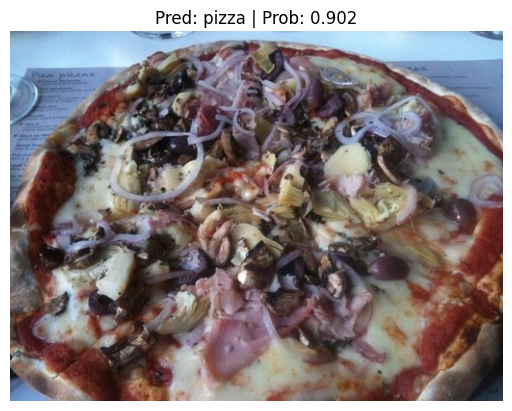

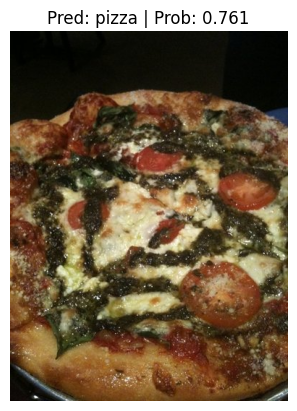

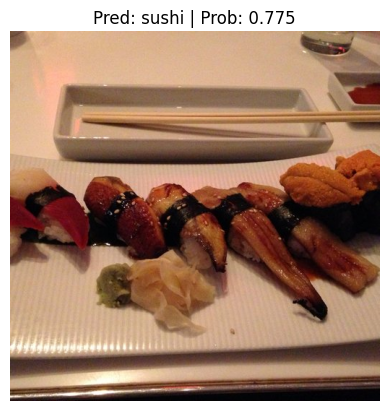

In [40]:
from going_modular.going_modular.predictions import pred_and_plot_image

import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg")) 
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) 

for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

data\04-pizza-dad.jpeg already exists, skipping download.


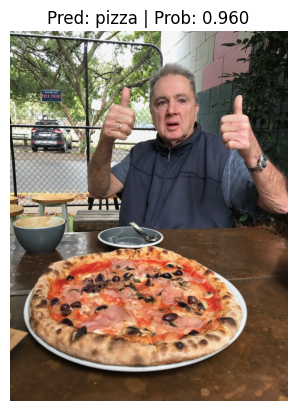

In [41]:
import requests

custom_image_path = Path("data/04-pizza-dad.jpeg")

if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/07_pytorch_experiment_tracking_exercise_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 07. PyTorch Experiment Tracking Exercise Template

Welcome to the 07. PyTorch Experiment Tracking exercise template notebook.

> **Note:** There may be more than one solution to each of the exercises. This notebook only shows one possible example.

## Resources

1. These exercises/solutions are based on [section 07. PyTorch Transfer Learning](https://www.learnpytorch.io/07_pytorch_experiment_tracking/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/cO_r2FYcAjU).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

We'll need to make sure we have `torch` v.1.12+ and `torchvision` v0.13+.

In [42]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cu113
torch version: 2.8.0+cpu
torchvision version: 0.23.0+cpu


In [43]:
 # Make sure we have a GPU
 device = "cuda" if torch.cuda.is_available() else "cpu"
 device

'cpu'

In [44]:
# Get regular imports 
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [45]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [46]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [47]:
from torch.utils.tensorboard import SummaryWriter
def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None):
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [48]:
# Create a test writer
writer = create_writer(experiment_name="test_experiment_name",
                       model_name="this_is_the_model_name",
                       extra="add_a_little_extra_if_you_want")

[INFO] Created SummaryWriter, saving to: runs\2025-09-09\test_experiment_name\this_is_the_model_name\add_a_little_extra_if_you_want...


In [49]:
from typing import Dict, List
from tqdm.auto import tqdm

from going_modular.going_modular.engine import train_step, test_step

# Add writer parameter to train()
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device, 
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Stores metrics to specified writer log_dir if present.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A SummaryWriter() instance to log model results to.

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

### Download data

Using the same data from https://www.learnpytorch.io/07_pytorch_experiment_tracking/

In [50]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data\pizza_steak_sushi directory exists, skipping download.
[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


In [51]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data\pizza_steak_sushi\train
Training directory 20%: data\pizza_steak_sushi_20_percent\train
Testing directory: data\pizza_steak_sushi\test


In [52]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225])

# Create a transform pipeline
simple_transform = transforms.Compose([
                                       transforms.Resize((224, 224)),
                                       transforms.ToTensor(), # get image values between 0 & 1
                                       normalize
])

### Turn data into DataLoaders 

In [53]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
                                                                                          test_dir=test_dir,
                                                                                          transform=simple_transform,
                                                                                          batch_size=BATCH_SIZE)

# Create 20% training and test DataLoaders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                          test_dir=test_dir,
                                                                                          transform=simple_transform,
                                                                                          batch_size=BATCH_SIZE)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(train_dataloader_10_percent)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 8 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


## Exercise 1: Pick a larger model from [`torchvision.models`](https://pytorch.org/vision/main/models.html) to add to the list of experiments (for example, EffNetB3 or higher)

* How does it perform compared to our existing models?
* **Hint:** You'll need to set up an exerpiment similar to [07. PyTorch Experiment Tracking section 7.6](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#76-create-experiments-and-set-up-training-code).

In [54]:
# TODO: your code
import torchvision.models as models
effnetv2_s_weights = models.EfficientNet_V2_S_Weights.DEFAULT 
effnetv2_s = models.efficientnet_v2_s(weights=effnetv2_s_weights)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to C:\Users\Dariusz Marecik/.cache\torch\hub\checkpoints\efficientnet_v2_s-dd5fe13b.pth


100%|██████████| 82.7M/82.7M [00:01<00:00, 71.3MB/s]


In [55]:
def create_effnetb2(out_features=len(class_names)):
    weight = models.EfficientNet_V2_S_Weights.DEFAULT 
    model = models.efficientnet_v2_s(weights=effnetv2_s_weights)
    dropout = 0.2
    in_features = 1408

    for param in model.features.parameters():
        param.requires_grad = False
    
    set_seeds()

    model.classifier = nn.Sequential(
        nn.Dropout(p = dropout, inplace=True),
        nn.Linear(in_features=in_features,
                  out_features=out_features)
    ).to(device)

    model.name = "effnetb2"
    print(f"[INFO] Creating {model.name} feature extractor model...")
    return model

def create_effnetv2_s(out_features=len(class_names)):
    weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
    model = torchvision.models.efficientnet_v2_s(weights=weights).to(device)
    dropout = 0.2
    in_features=1280

    for param in model.features.parameters():
      param.requires_grad=False

    set_seeds() 

    model.classifier = nn.Sequential(
        nn.Dropout(p=dropout, inplace=True),
        nn.Linear(in_features=in_features, 
                  out_features=out_features)
    ).to(device) 

    model.name = "effnetv2_s"
    print(f"[INFO] Creating {model.name} feature extractor model...")
    return model

In [ ]:
from going_modular.going_modular.utils import save_model

set_seeds(seed=42)

experiment_number = 0

for dataloader_name, train_dataloader in train_dataloaders.items():

    for epochs in num_epochs: 

        for model_name in models:

            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            if model_name == "effnetb2":
              model = create_effnetb2()
            else:
              model = create_effnetv2_s()

            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))

            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

## Exercise 2. Introduce data augmentation to the list of experiments using the 20% pizza, steak, sushi training and test datasets, does this change anything?
    
* For example, you could have one training DataLoader that uses data augmentation (e.g. `train_dataloader_20_percent_aug` and `train_dataloader_20_percent_no_aug`) and then compare the results of two of the same model types training on these two DataLoaders.
* **Note:** You may need to alter the `create_dataloaders()` function to be able to take a transform for the training data and the testing data (because you don't need to perform data augmentation on the test data). See [04. PyTorch Custom Datasets section 6](https://www.learnpytorch.io/04_pytorch_custom_datasets/#6-other-forms-of-transforms-data-augmentation) for examples of using data augmentation or the script below for an example:

```python
# Note: Data augmentation transform like this should only be performed on training data
train_transform_data_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    normalize
])

# Create a helper function to visualize different augmented (and not augmented) images
def view_dataloader_images(dataloader, n=10):
    if n > 10:
        print(f"Having n higher than 10 will create messy plots, lowering to 10.")
        n = 10
    imgs, labels = next(iter(dataloader))
    plt.figure(figsize=(16, 8))
    for i in range(n):
        # Min max scale the image for display purposes
        targ_image = imgs[i]
        sample_min, sample_max = targ_image.min(), targ_image.max()
        sample_scaled = (targ_image - sample_min)/(sample_max - sample_min)

        # Plot images with appropriate axes information
        plt.subplot(1, 10, i+1)
        plt.imshow(sample_scaled.permute(1, 2, 0)) # resize for Matplotlib requirements
        plt.title(class_names[labels[i]])
        plt.axis(False)

# Have to update `create_dataloaders()` to handle different augmentations
import os
from torch.utils.data import DataLoader
from torchvision import datasets

NUM_WORKERS = os.cpu_count() # use maximum number of CPUs for workers to load data 

# Note: this is an update version of data_setup.create_dataloaders to handle
# differnt train and test transforms.
def create_dataloaders(
    train_dir, 
    test_dir, 
    train_transform, # add parameter for train transform (transforms on train dataset)
    test_transform,  # add parameter for test transform (transforms on test dataset)
    batch_size=32, num_workers=NUM_WORKERS
):
    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=train_transform)
    test_data = datasets.ImageFolder(test_dir, transform=test_transform)

    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names
```

In [57]:
# TODO: your code
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225])

data_aug_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    normalize
])

# Create a non-data aug transform
no_data_aug_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [58]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    train_transform: transforms.Compose, 
    test_transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
 
  train_data = datasets.ImageFolder(train_dir, 
                                    transform=train_transform)
  test_data = datasets.ImageFolder(test_dir, 
                                   transform=test_transform)

  class_names = train_data.classes

  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [59]:
train_20_percent_dir = image_path / "train"
test_20_percent_dir = image_path / "test"

BATCH_SIZE = 32

train_dataloader_20_percent_with_aug, test_dataloader_20_percent, class_names = create_dataloaders(train_dir=train_20_percent_dir,
                                                                                                   test_dir=test_20_percent_dir,
                                                                                                   train_transform=data_aug_transform,
                                                                                                   test_transform=no_data_aug_transform,
                                                                                                   batch_size=BATCH_SIZE)

train_dataloader_20_percent_without_aug, test_dataloader_20_percent, class_names = create_dataloaders(train_dir=train_20_percent_dir,
                                                                                                   test_dir=test_20_percent_dir,
                                                                                                   train_transform=no_data_aug_transform,
                                                                                                   test_transform=no_data_aug_transform,
                                                                                                   batch_size=BATCH_SIZE)

In [60]:
def view_dataloader_images(dataloader, n=10):
    if n > 10:
        print(f"Having n higher than 10 will create messy plots, lowering to 10.")
        n = 10
    imgs, labels = next(iter(dataloader))
    plt.figure(figsize=(16, 8))
    for i in range(n):
        targ_image = imgs[i]
        sample_min, sample_max = targ_image.min(), targ_image.max()
        sample_scaled = (targ_image - sample_min)/(sample_max - sample_min)

        plt.subplot(1, 10, i+1)
        plt.imshow(sample_scaled.permute(1, 2, 0)) 
        plt.title(class_names[labels[i]])
        plt.axis(False)

d:\pytorch exercise\venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


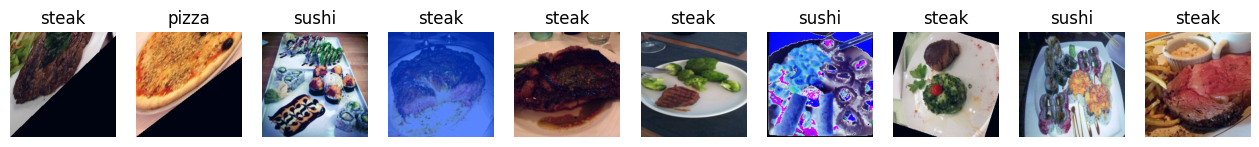

In [61]:
view_dataloader_images(train_dataloader_20_percent_with_aug)

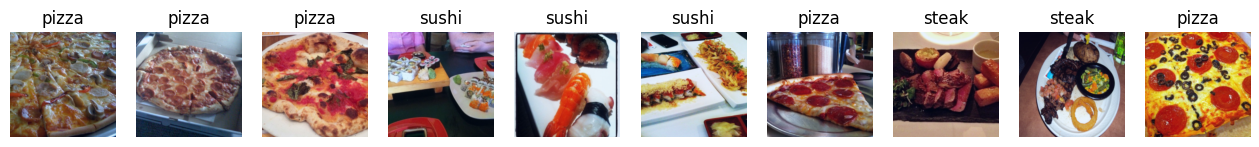

In [62]:
view_dataloader_images(train_dataloader_20_percent_without_aug)

In [63]:
num_epochs = [5, 10]

train_dataloaders = {"data_20_percent_with_aug": train_dataloader_20_percent_with_aug,
                     "data_20_percent_without_aug": train_dataloader_20_percent_without_aug}

models = ["effnetv2_s"]

In [ ]:
from going_modular.going_modular.utils import save_model

set_seeds(seed=42)

experiment_number = 0

for dataloader_name, train_dataloader in train_dataloaders.items():

    for epochs in num_epochs: 

        for model_name in models:

            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            if model_name == "effnetb2":
              model = create_effnetb2()
            else:
              model = create_effnetv2_s()

            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))

            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

## Exercise 3. Scale up the dataset to turn FoodVision Mini into FoodVision Big using the entire [Food101 dataset from `torchvision.models`](https://pytorch.org/vision/stable/generated/torchvision.datasets.Food101.html#torchvision.datasets.Food101)
    
* You could take the best performing model from your various experiments or even the EffNetB2 feature extractor we created in this notebook and see how it goes fitting for 5 epochs on all of Food101.
* If you try more than one model, it would be good to have the model's results tracked.
* If you load the Food101 dataset from `torchvision.models`, you'll have to create PyTorch DataLoaders to use it in training.
* **Note:** Due to the larger amount of data in Food101 compared to our pizza, steak, sushi dataset, this model will take longer to train.

In [64]:
# TODO: your code

import torchvision
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

simple_transform = transforms.Compose([
                                       transforms.Resize((224, 224)),
                                       transforms.ToTensor(), 
                                       normalize
])

train_data = torchvision.datasets.Food101(root="data",
                                          split="train",
                                          transform=simple_transform,
                                          download=True)

test_data = torchvision.datasets.Food101(root="data",
                                        split="test",
                                        transform=simple_transform,
                                        download=True)

100%|██████████| 5.00G/5.00G [21:04<00:00, 3.95MB/s] 


In [65]:
len(train_data), len(test_data)

(75750, 25250)

In [66]:
import os
BATCH_SIZE = 512 

train_dataloader_big = torch.utils.data.DataLoader(train_data,
                                                   shuffle=True,
                                                   batch_size=BATCH_SIZE,
                                                   num_workers=os.cpu_count(),
                                                   pin_memory=True) 

test_dataloader_big = torch.utils.data.DataLoader(test_data,
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE,
                                                  num_workers=os.cpu_count(),
                                                  pin_memory=True)

In [67]:
effnetv2_s_weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
foodvision_big_model = torchvision.models.efficientnet_v2_s(weights=effnetv2_s_weights).to(device)

for param in foodvision_big_model.features.parameters():
  param.requires_grad = False

foodvision_big_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(in_features=1280, out_features=101) 
).to(device)


In [68]:
foodvision_big_results = train(model=foodvision_big_model,
                               train_dataloader=train_dataloader_big,
                               test_dataloader=test_dataloader_big,
                               optimizer=torch.optim.Adam(params=foodvision_big_model.parameters(), lr=0.001),
                               loss_fn=torch.nn.CrossEntropyLoss(),
                               epochs=5,
                               device=device,
                               writer=create_writer(experiment_name="food101_all_data",
                                                    model_name="foodvision_big",
                                                    extra=f"{epochs}_epochs"))

[INFO] Created SummaryWriter, saving to: runs\2025-09-09\food101_all_data\foodvision_big\10_epochs...


  0%|          | 0/5 [02:14<?, ?it/s]


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "d:\pytorch exercise\venv\Lib\site-packages\torch\utils\data\_utils\worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "d:\pytorch exercise\venv\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "d:\pytorch exercise\venv\Lib\site-packages\torch\utils\data\_utils\collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\pytorch exercise\venv\Lib\site-packages\torch\utils\data\_utils\collate.py", line 211, in collate
    return [
           ^
  File "d:\pytorch exercise\venv\Lib\site-packages\torch\utils\data\_utils\collate.py", line 212, in <listcomp>
    collate(samples, collate_fn_map=collate_fn_map)
  File "d:\pytorch exercise\venv\Lib\site-packages\torch\utils\data\_utils\collate.py", line 155, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\pytorch exercise\venv\Lib\site-packages\torch\utils\data\_utils\collate.py", line 270, in collate_tensor_fn
    storage = elem._typed_storage()._new_shared(numel, device=elem.device)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\pytorch exercise\venv\Lib\site-packages\torch\storage.py", line 1203, in _new_shared
    untyped_storage = torch.UntypedStorage._new_shared(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\pytorch exercise\venv\Lib\site-packages\torch\storage.py", line 414, in _new_shared
    return cls._new_using_filename_cpu(size)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: Couldn't open shared file mapping: <torch_10076_1220825162_0>, error code: <1455>
